In [1]:
import os
import sys
import random
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from core import (Dimension, Space, Point, Flow, Block, StatefulTransform, SignalGeneratorBlock, Pipeline)


##### Random Walk with Signal Generator Block

This simulation demonstrates a simple random walk using a SignalGeneratorBlock. The random walk is implemented in one-dimensional space, where the position is updated at each step by a random increment.

In [4]:
def random_walk_signal(state):
    increment = random.uniform(-1, 1)
    state['position'] += increment
    return {'position': state['position']}

dim_position = Dimension(name='position')
space_position = Space(name='LaserSpace', dimensions=[dim_position])

initial_state = {'position': 0.0}
random_walk_generator = SignalGeneratorBlock(
    name='RandomWalkGenerator',
    codomain=space_position,
    signal_function=random_walk_signal,
    initial_state=initial_state
)

pipeline = Pipeline()
pipeline.add_block(random_walk_generator)
current_flow = Flow()
for step in range(10):
    current_flow = pipeline.run(current_flow)
    position_point = current_flow.get_point('LaserSpace')
    print(f"Step {step + 1}: LaserSpace = {position_point.values['position']}")


Step 1: LaserSpace = 0.9780136712979546
Step 2: LaserSpace = 0.5692500796426958
Step 3: LaserSpace = 1.508135456348176
Step 4: LaserSpace = 2.2621811325114294
Step 5: LaserSpace = 2.2201919455180965
Step 6: LaserSpace = 2.551092039964109
Step 7: LaserSpace = 3.457989066382603
Step 8: LaserSpace = 3.3328934958892553
Step 9: LaserSpace = 2.516070624656628
Step 10: LaserSpace = 1.5217433764369142


##### Random Walk with only primitives

This simulation demonstrates a simple random walk using a StatefulTransform.

In [10]:
from core import Dimension, Space, Point, Flow, StatefulTransform, Block, Pipeline
import random

# Step 1: Define the Dimension
dim_position = Dimension(name='position')

# Step 2: Define the Space
space_position = Space(name='PositionSpace', dimensions=[dim_position])

# Step 3: Define the Initial Point
initial_position_point = Point(space=space_position, values={'position': 0.0})

# Step 4: Create the Initial Flow
flow = Flow(points={'PositionSpace': initial_position_point})

# Step 5: Define the Random Walk Transform
def random_walk_function(inputs, state):
    position = inputs['position']
    increment = random.uniform(-1, 1)  # Random increment between -1 and 1
    new_position = position + increment
    return {'position': new_position}, state  # No state update needed

random_walk_transform = StatefulTransform(
    name='RandomWalkTransform',
    domain=space_position,
    codomain=space_position,
    function=random_walk_function
)

# Step 6: Create the Block
random_walk_block = Block(name='RandomWalkBlock', transform=random_walk_transform)

# Step 7: Set Up the Pipeline
pipeline = Pipeline()
pipeline.add_block(random_walk_block)

# Step 8: Run the Simulation
for step in range(10):
    flow = pipeline.run(flow)
    position_point = flow.get_point('PositionSpace')
    print(f"Step {step + 1}: Position = {position_point.values['position']}")


Step 1: Position = -0.08911389341430453
Step 2: Position = -0.36181210550264464
Step 3: Position = 0.5477768393276115
Step 4: Position = 0.9130960029796598
Step 5: Position = 0.4820789097479834
Step 6: Position = -0.4911970331204498
Step 7: Position = -1.296237571008929
Step 8: Position = -1.1937032344619427
Step 9: Position = -1.8495618608368922
Step 10: Position = -1.8951012879824012


##### Cat chasing LaserPointer (random walk) with custom Block
This code simulates a cat chasing a laser pointer in a 2D space, where the laser moves randomly and the cat follows it, updating their positions over 60 time steps and printing the results.

In [ ]:
# Define the Position Space for 2D
position_dimensions = [Dimension('x'), Dimension('y')]
laser_space = Space('LaserSpace', [Dimension('L_x'), Dimension('L_y')])
cat_space = Space('CatSpace', [Dimension('C_x'), Dimension('C_y')])

# Initial Positions
initial_laser_position = Point(laser_space, {'L_x': 5.0, 'L_y': 5.0})
initial_cat_position = Point(cat_space, {'C_x': 0.0, 'C_y': 0.0})

# Laser Pointer Signal Generator Block
def laser_movement_function(state):
    # Randomly move the laser pointer within bounds
    delta_x = random.uniform(-1, 1)
    delta_y = random.uniform(-1, 1)
    L_x = state.get('L_x', initial_laser_position.values['L_x']) + delta_x
    L_y = state.get('L_y', initial_laser_position.values['L_y']) + delta_y
    output_values = {'L_x': L_x, 'L_y': L_y}
    return output_values

# Uncomment to show the cat moving closer to the laser
# def laser_movement_function(state):
#     # Randomly move the laser pointer within bounds
#     L_x = state.get('L_x', initial_laser_position.values['L_x'])
#     L_y = state.get('L_y', initial_laser_position.values['L_y'])
#     output_values = {'L_x': L_x, 'L_y': L_y}
#     return output_values

laser_generator_block = SignalGeneratorBlock(
    name='LaserPointerGenerator',
    codomain=laser_space,
    signal_function=laser_movement_function,
    initial_state={'L_x': initial_laser_position.values['L_x'], 'L_y': initial_laser_position.values['L_y']}
)

# Cat Movement Block
class CatChasingLaserBlock(Block):
    def __init__(self, name: str, cat_space: Space, laser_space: Space, cat_speed: float):
        def cat_movement_function(input_values, state):
            # input_values contains 'L_x' and 'L_y' from the laser_space
            L_x = input_values['L_x']
            L_y = input_values['L_y']
            C_x = state.get('C_x', initial_cat_position.values['C_x'])
            C_y = state.get('C_y', initial_cat_position.values['C_y'])
            # Calculate direction vector
            delta_x = L_x - C_x
            delta_y = L_y - C_y
            distance = np.hypot(delta_x, delta_y)
            if distance == 0:
                # Cat is at the laser pointer's position
                new_C_x, new_C_y = C_x, C_y
            else:
                # Move cat towards laser pointer
                new_C_x = C_x + cat_speed * (delta_x / distance)
                new_C_y = C_y + cat_speed * (delta_y / distance)
            state['C_x'] = new_C_x
            state['C_y'] = new_C_y
            output_values = {'C_x': new_C_x, 'C_y': new_C_y}
            return output_values, state

        transform = StatefulTransform(
            name=f"{name}_transform",
            domain=laser_space,
            codomain=cat_space,
            function=cat_movement_function,
            initial_state={'C_x': initial_cat_position.values['C_x'], 'C_y': initial_cat_position.values['C_y']}
        )
        super().__init__(name, transform)

cat_speed = 0.5  # Cat's speed
cat_chasing_block = CatChasingLaserBlock(
    name='CatChasingLaser',
    cat_space=cat_space,
    laser_space=laser_space,
    cat_speed=cat_speed
)

# Build the Pipeline
pipeline = Pipeline()
pipeline.add_block(laser_generator_block)
pipeline.add_block(cat_chasing_block)
pipeline.connect_blocks(laser_generator_block, cat_chasing_block)


# Run the Simulation for 100 steps
flow = Flow()
positions = [pipeline.run(flow) for _ in range(100)]

laser_positions = [(p.get_point('LaserSpace').values['L_x'], p.get_point('LaserSpace').values['L_y']) for p in positions]
cat_positions = [(p.get_point('CatSpace').values['C_x'], p.get_point('CatSpace').values['C_y']) for p in positions]

# Print results if needed
for t, (laser, cat) in enumerate(zip(laser_positions, cat_positions)):
    print(f"Time {t}:")
    print(f"  Laser Position: ({laser[0]:.2f}, {laser[1]:.2f})")
    print(f"  Cat Position: ({cat[0]:.2f}, {cat[1]:.2f})")



In [ ]:
import matplotlib.pyplot as plt

# Splitting positions into x and y for plotting
laser_x, laser_y = zip(*laser_positions)
cat_x, cat_y = zip(*cat_positions)

# Plotting the trajectories of the laser, cat, and dog
plt.figure(figsize=(12, 8))

plt.plot(laser_x, laser_y, 'r-', label='Laser Pointer Trajectory')
plt.plot(cat_x, cat_y, 'b-', label='Cat Trajectory')

plt.scatter(laser_x, laser_y, color='r', s=10, label='Laser Positions')
plt.scatter(cat_x, cat_y, color='b', s=10, label='Cat Positions')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Trajectory of Laser Pointer, Cat Over Time')
plt.legend()
plt.grid()
plt.show()


In [11]:
# Define the Position Space for 2D
position_dimensions = [Dimension('x'), Dimension('y')]
laser_space = Space('LaserSpace', [Dimension('L_x'), Dimension('L_y')])
cat_space = Space('CatSpace', [Dimension('C_x'), Dimension('C_y')])
dog_space = Space('DogSpace', [Dimension('D_x'), Dimension('D_y')])

# Initial Dog Position
initial_laser_position = Point(laser_space, {'L_x': 5.0, 'L_y': 5.0})
initial_cat_position = Point(cat_space, {'C_x': 0.0, 'C_y': 0.0})
initial_dog_position = Point(dog_space, {'D_x': -5.0, 'D_y': -5.0})

def laser_movement_function(state):
    # Randomly move the laser pointer within bounds
    delta_x = random.uniform(-1, 1)
    delta_y = random.uniform(-1, 1)
    L_x = state.get('L_x', initial_laser_position.values['L_x']) + delta_x
    L_y = state.get('L_y', initial_laser_position.values['L_y']) + delta_y
    output_values = {'L_x': L_x, 'L_y': L_y}
    return output_values

# Uncomment to show the dog, cat moving closer to each other 
# def laser_movement_function(state):
#     # Randomly move the laser pointer within bounds
#     L_x = state.get('L_x', initial_laser_position.values['L_x'])
#     L_y = state.get('L_y', initial_laser_position.values['L_y'])
#     output_values = {'L_x': L_x, 'L_y': L_y}
#     return output_values


laser_generator_block = SignalGeneratorBlock(
    name='LaserPointerGenerator',
    codomain=laser_space,
    signal_function=laser_movement_function,
    initial_state={'L_x': initial_laser_position.values['L_x'], 'L_y': initial_laser_position.values['L_y']}
)

# Cat Movement Block
class CatChasingLaserBlock(Block):
    def __init__(self, name: str, cat_space: Space, laser_space: Space, cat_speed: float):
        def cat_movement_function(input_values, state):
            # input_values contains 'L_x' and 'L_y' from the laser_space
            L_x = input_values['L_x']
            L_y = input_values['L_y']
            C_x = state.get('C_x', initial_cat_position.values['C_x'])
            C_y = state.get('C_y', initial_cat_position.values['C_y'])
            # Calculate direction vector
            delta_x = L_x - C_x
            delta_y = L_y - C_y
            distance = np.hypot(delta_x, delta_y)
            if distance == 0:
                # Cat is at the laser pointer's position
                new_C_x, new_C_y = C_x, C_y
            else:
                # Move cat towards laser pointer
                new_C_x = C_x + cat_speed * (delta_x / distance)
                new_C_y = C_y + cat_speed * (delta_y / distance)
            state['C_x'] = new_C_x
            state['C_y'] = new_C_y
            output_values = {'C_x': new_C_x, 'C_y': new_C_y}
            return output_values, state

        transform = StatefulTransform(
            name=f"{name}_transform",
            domain=laser_space,
            codomain=cat_space,
            function=cat_movement_function,
            initial_state={'C_x': initial_cat_position.values['C_x'], 'C_y': initial_cat_position.values['C_y']}
        )
        super().__init__(name, transform)

cat_speed = 0.5  # Cat's speed
cat_chasing_block = CatChasingLaserBlock(
    name='CatChasingLaser',
    cat_space=cat_space,
    laser_space=laser_space,
    cat_speed=cat_speed
)

# Dog Movement Block
class DogChasingCatBlock(Block):
    def __init__(self, name: str, dog_space: Space, cat_space: Space, dog_speed: float):
        def dog_movement_function(input_values, state):
            # input_values contains 'C_x' and 'C_y' from the cat_space
            C_x = input_values['C_x']
            C_y = input_values['C_y']
            D_x = state.get('D_x', initial_dog_position.values['D_x'])
            D_y = state.get('D_y', initial_dog_position.values['D_y'])
            # Calculate direction vector
            delta_x = C_x - D_x
            delta_y = C_y - D_y
            distance = np.hypot(delta_x, delta_y)
            if distance == 0:
                # Dog is at the cat's position
                new_D_x, new_D_y = D_x, D_y
            else:
                # Move dog towards cat
                new_D_x = D_x + dog_speed * (delta_x / distance)
                new_D_y = D_y + dog_speed * (delta_y / distance)
            state['D_x'] = new_D_x
            state['D_y'] = new_D_y
            output_values = {'D_x': new_D_x, 'D_y': new_D_y}
            return output_values, state

        transform = StatefulTransform(
            name=f"{name}_transform",
            domain=cat_space,
            codomain=dog_space,
            function=dog_movement_function,
            initial_state={'D_x': initial_dog_position.values['D_x'], 'D_y': initial_dog_position.values['D_y']}
        )
        super().__init__(name, transform)

dog_speed = 0.7  # Dog's speed
dog_chasing_block = DogChasingCatBlock(
    name='DogChasingCat',
    dog_space=dog_space,
    cat_space=cat_space,
    dog_speed=dog_speed
)

# Build the Pipeline
pipeline = Pipeline()
pipeline.add_block(laser_generator_block)
pipeline.add_block(cat_chasing_block)
pipeline.connect_blocks(laser_generator_block, cat_chasing_block)
pipeline.add_block(dog_chasing_block)
pipeline.connect_blocks(cat_chasing_block, dog_chasing_block)


# Run the Simulation for 100 steps
flow = Flow()
positions = [pipeline.run(flow) for _ in range(100)]

laser_positions = [(p.get_point('LaserSpace').values['L_x'], p.get_point('LaserSpace').values['L_y']) for p in positions]
cat_positions = [(p.get_point('CatSpace').values['C_x'], p.get_point('CatSpace').values['C_y']) for p in positions]
dog_positions = [(p.get_point('DogSpace').values['D_x'], p.get_point('DogSpace').values['D_y']) for p in positions]

# Print results if needed
for t, (laser, cat, dog) in enumerate(zip(laser_positions, cat_positions, dog_positions)):
    print(f"Time {t}:")
    print(f"  Laser Position: ({laser[0]:.2f}, {laser[1]:.2f})")
    print(f"  Cat Position: ({cat[0]:.2f}, {cat[1]:.2f})")
    print(f"  Dog Position: ({dog[0]:.2f}, {dog[1]:.2f})")


Time 0:
  Laser Position: (5.40, 4.85)
  Cat Position: (0.37, 0.33)
  Dog Position: (-4.50, -4.51)
Time 1:
  Laser Position: (5.47, 4.71)
  Cat Position: (0.75, 0.66)
  Dog Position: (-4.00, -4.02)
Time 2:
  Laser Position: (4.84, 5.65)
  Cat Position: (1.07, 1.05)
  Dog Position: (-3.51, -3.52)
Time 3:
  Laser Position: (5.72, 5.36)
  Cat Position: (1.43, 1.39)
  Dog Position: (-3.01, -3.03)
Time 4:
  Laser Position: (5.44, 4.70)
  Cat Position: (1.82, 1.71)
  Dog Position: (-2.51, -2.54)
Time 5:
  Laser Position: (4.36, 5.78)
  Cat Position: (2.08, 2.13)
  Dog Position: (-2.02, -2.04)
Time 6:
  Laser Position: (5.42, 4.02)
  Cat Position: (2.52, 2.38)
  Dog Position: (-1.52, -1.55)
Time 7:
  Laser Position: (5.57, 4.52)
  Cat Position: (2.93, 2.66)
  Dog Position: (-1.01, -1.07)
Time 8:
  Laser Position: (5.66, 4.02)
  Cat Position: (3.38, 2.89)
  Dog Position: (-0.49, -0.60)
Time 9:
  Laser Position: (5.06, 4.76)
  Cat Position: (3.71, 3.26)
  Dog Position: (0.02, -0.13)
Time 10:
  

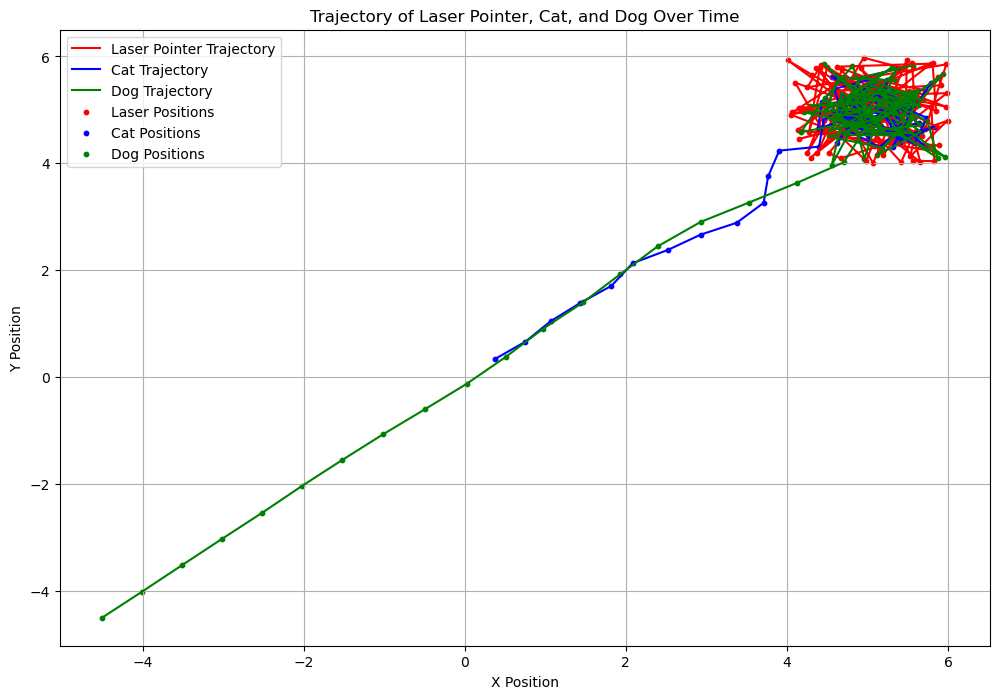

In [12]:
import matplotlib.pyplot as plt

# Splitting positions into x and y for plotting
laser_x, laser_y = zip(*laser_positions)
cat_x, cat_y = zip(*cat_positions)
dog_x, dog_y = zip(*dog_positions)

# Plotting the trajectories of the laser, cat, and dog
plt.figure(figsize=(12, 8))

plt.plot(laser_x, laser_y, 'r-', label='Laser Pointer Trajectory')
plt.plot(cat_x, cat_y, 'b-', label='Cat Trajectory')
plt.plot(dog_x, dog_y, 'g-', label='Dog Trajectory')

plt.scatter(laser_x, laser_y, color='r', s=10, label='Laser Positions')
plt.scatter(cat_x, cat_y, color='b', s=10, label='Cat Positions')
plt.scatter(dog_x, dog_y, color='g', s=10, label='Dog Positions')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Trajectory of Laser Pointer, Cat, and Dog Over Time')
plt.legend()
plt.grid()
plt.show()
